<a href="https://colab.research.google.com/github/koohaoming/SnapItFindIt/blob/main/CNN_F1_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References: https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb


In [1]:
import requests
import pandas as pd
import bs4 as bs
import urllib.request
import re
from time import time
from datetime import datetime
from tqdm import tqdm

import csv
import seaborn as sns

import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow.keras

from tensorflow.keras.layers import Flatten, Dense, Input
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow

# Check GPU setup in Colab
%tensorflow_version 1.x
import tensorflow as tf

# Silence the tensorflow warning message
tf.get_logger().setLevel('ERROR')

# Check GPU coinfiguration in Colab (T4 GPU)
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'


TensorFlow is already loaded. Please restart the runtime to change versions.
Tensorflow version:  2.4.1
/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/isy5004_project/')
!ls

Mounted at /content/gdrive
'background removal.ipynb'
 best_inception_model.h5
'CNN Modeling.ipynb'
 data
'Detectron2 YS.ipynb'
 hipvan_image
 ikea_image
'ikea scrapper.ipynb'
 input.jpg
 Mask_RCNN
 mask_rcnn_coco.h5
 models
 object_detection_classes_yolov3.txt
'Object Detection with BB and object counting.ipynb'
'Object Detection with BB.ipynb'
 production_ready_code
 telegram_bot.ipynb
 temp
 utils.py
 web_scraper.ipynb
'work breakdown.gsheet'
 yolov3.cfg
 yolov3.weights


In [ ]:
# Compare the input query file name and the result file name lists to calculate the precision performance
# For example
# input_file_name: data/scene/train/Mountain/image_0076.jpg
# result_file_name_list: a list of top_return files in query results
def cal_precision(input_file_name, result_file_name_list):
    num = 0
    id = re.search(r'.*_(\d*)', input_file_name.split("/")[2]).group(1)
    input_class = all_data[all_data.id == id].category_name.to_list()
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[1]
        if result_class in input_class:
            num = num+1
    return (num/len(result_file_name_list))

def cal_accuracy(input_file_name, result_file_name_list):
    result = 0
    id = re.search(r'.*_(\d*)', input_file_name.split("/")[2]).group(1)
    input_class = all_data[all_data.id == id].category_name.to_list()
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[1]
        if result_class in input_class:
            result = 1
            break
    return (result)

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)


def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset


To train a model on our dataset you want the data to be:
Well shuffled
Batched
Batches to be available as soon as possible.
These features can be easily added using the tf.data.Dataset abstraction.

AUTOTUNE will adapt the preprocessing and prefetching workload to model training and batch consumption. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. AUTOTUNE will prompt the tf.data runtime to tune the value dynamically at runtime.


In [ ]:
#Define Variables

IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 256 # Shuffle the training data by a chunck of 1024 observations


In [ ]:
all_data = pd.read_csv('data/ikea_products.csv', index_col=False)

In [ ]:
all_data.head()

,Unnamed: 0,name,typeName,itemMeasureReferenceText,mainImageUrl,pipUrl,id,itemNoGlobal,metadata,onlineSellable,lastChance,gprDescription,colors,priceNumeral,currencyCode,category_code,category_name
0,0,LÄTT,Children's table with 2 chairs,NaN,https://www.ikea.com/sg/en/images/products/lae...,https://www.ikea.com/sg/en/p/laett-childrens-t...,10178413,50178411,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'beige', 'id': '10003', 'hex': 'f4f3...",29.9,SGD,18767,Children's small furniture
1,1,FLISAT,Children's table,83x58 cm,https://www.ikea.com/sg/en/images/products/fli...,https://www.ikea.com/sg/en/p/flisat-childrens-...,30298419,50298418,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'beige', 'id': '10003', 'hex': 'f4f3...",89.0,SGD,18767,Children's small furniture
2,2,DUNDRA,Activity table with storage,NaN,https://www.ikea.com/sg/en/images/products/dun...,https://www.ikea.com/sg/en/p/dundra-activity-t...,80472500,30472499,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'white', 'id': '10156', 'hex': 'ffff...",159.0,SGD,18767,Children's small furniture
3,3,SUNDVIK,Children's table,76x50 cm,https://www.ikea.com/sg/en/images/products/sun...,https://www.ikea.com/sg/en/p/sundvik-childrens...,90201674,10201673,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'white', 'id': '10156', 'hex': 'ffff...",59.0,SGD,18767,Children's small furniture
4,4,SLÄKT,"Pouffe/mattress, foldable",NaN,https://www.ikea.com/sg/en/images/products/sla...,https://www.ikea.com/sg/en/p/slaekt-pouffe-mat...,90362964,10362963,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'grey', 'id': '10028', 'hex': '94949...",90.0,SGD,18767,Children's small furniture


In [ ]:
all_data[all_data['id']=='10178413']

,Unnamed: 0,name,typeName,itemMeasureReferenceText,mainImageUrl,pipUrl,id,itemNoGlobal,metadata,onlineSellable,lastChance,gprDescription,colors,priceNumeral,currencyCode,category_code,category_name
0,0,LÄTT,Children's table with 2 chairs,NaN,https://www.ikea.com/sg/en/images/products/lae...,https://www.ikea.com/sg/en/p/laett-childrens-t...,10178413,50178411,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'beige', 'id': '10003', 'hex': 'f4f3...",29.9,SGD,18767,Children's small furniture
427,4,LÄTT,Children's table with 2 chairs,NaN,https://www.ikea.com/sg/en/images/products/lae...,https://www.ikea.com/sg/en/p/laett-childrens-t...,10178413,50178411,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'beige', 'id': '10003', 'hex': 'f4f3...",29.9,SGD,bc003,Children
5917,172,LÄTT,Children's table with 2 chairs,NaN,https://www.ikea.com/sg/en/images/products/lae...,https://www.ikea.com/sg/en/p/laett-childrens-t...,10178413,50178411,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'beige', 'id': '10003', 'hex': 'f4f3...",29.9,SGD,fu004,Tables & desks


In [ ]:

#checking the available data scraped off Ikea
print("Number of rows in data =",all_data.shape[0])
print("Number of columns in data =",all_data.shape[1])
print("\n")
print("**Sample data:**")
all_data.head()


Number of rows in data = 12418
Number of columns in data = 17


**Sample data:**


,Unnamed: 0,name,typeName,itemMeasureReferenceText,mainImageUrl,pipUrl,id,itemNoGlobal,metadata,onlineSellable,lastChance,gprDescription,colors,priceNumeral,currencyCode,category_code,category_name
0,0,LÄTT,Children's table with 2 chairs,NaN,https://www.ikea.com/sg/en/images/products/lae...,https://www.ikea.com/sg/en/p/laett-childrens-t...,10178413,50178411,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'beige', 'id': '10003', 'hex': 'f4f3...",29.9,SGD,18767,Children's small furniture
1,1,FLISAT,Children's table,83x58 cm,https://www.ikea.com/sg/en/images/products/fli...,https://www.ikea.com/sg/en/p/flisat-childrens-...,30298419,50298418,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'beige', 'id': '10003', 'hex': 'f4f3...",89.0,SGD,18767,Children's small furniture
2,2,DUNDRA,Activity table with storage,NaN,https://www.ikea.com/sg/en/images/products/dun...,https://www.ikea.com/sg/en/p/dundra-activity-t...,80472500,30472499,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'white', 'id': '10156', 'hex': 'ffff...",159.0,SGD,18767,Children's small furniture
3,3,SUNDVIK,Children's table,76x50 cm,https://www.ikea.com/sg/en/images/products/sun...,https://www.ikea.com/sg/en/p/sundvik-childrens...,90201674,10201673,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'white', 'id': '10156', 'hex': 'ffff...",59.0,SGD,18767,Children's small furniture
4,4,SLÄKT,"Pouffe/mattress, foldable",NaN,https://www.ikea.com/sg/en/images/products/sla...,https://www.ikea.com/sg/en/p/slaekt-pouffe-mat...,90362964,10362963,Relevance PLP,True,False,"{'numberOfVariants': 0, 'variants': []}","[{'name': 'grey', 'id': '10028', 'hex': '94949...",90.0,SGD,18767,Children's small furniture


Not to self, that we might need to drop less than 10 etc as it is hard to predict due to lack of sufficient data. Model should not focus on predicting the labels etc

In [ ]:
# only include class with more than 5 images
image_file_list = all_data.groupby('category_name').count().name.reset_index()[all_data.groupby('category_name').count().name.reset_index().name > 20].category_name.to_list()

# Prepare the training folder and image file list
image_folder_name = 'ikea_image'
image_file_path = []
for subfolder in image_file_list:
    file_list = os.listdir(image_folder_name + '/' + subfolder)
    for file in file_list:
        image_file_path.append(image_folder_name + '/' + subfolder + '/' + file)

# Prints to tell how many classes < 5 images, and total images available
print("DataSet: %d classes, %d images" % (len(image_file_list), len(image_file_path)))

#creates a dataframe with category as labels
image_file_path_df = pd.DataFrame({'image_file_path': image_file_path})

#Subfolder is named after category
image_file_path_df['label'] = image_file_path_df.image_file_path.str.split(pat = '/').str[1]


DataSet: 85 classes, 12249 images


In [ ]:
image_file_path_df

,image_file_path,label
0,ikea_image/Alarm clock & wall clocks/TROMMA_Wa...,Alarm clock & wall clocks
1,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,Alarm clock & wall clocks
2,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,Alarm clock & wall clocks
3,ikea_image/Alarm clock & wall clocks/KLOCKIS_C...,Alarm clock & wall clocks
4,ikea_image/Alarm clock & wall clocks/TJALLA_Wa...,Alarm clock & wall clocks
...,...,...
12244,ikea_image/Worktops for METOD/FIXA_Worktop cov...,Worktops for METOD
12245,ikea_image/Worktops for METOD/FIXA_Diffusion b...,Worktops for METOD
12246,ikea_image/Worktops for METOD/SKOGSÅ_Worktop_...,Worktops for METOD
12247,ikea_image/Worktops for METOD/SÄLJAN_Worktop_...,Worktops for METOD


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


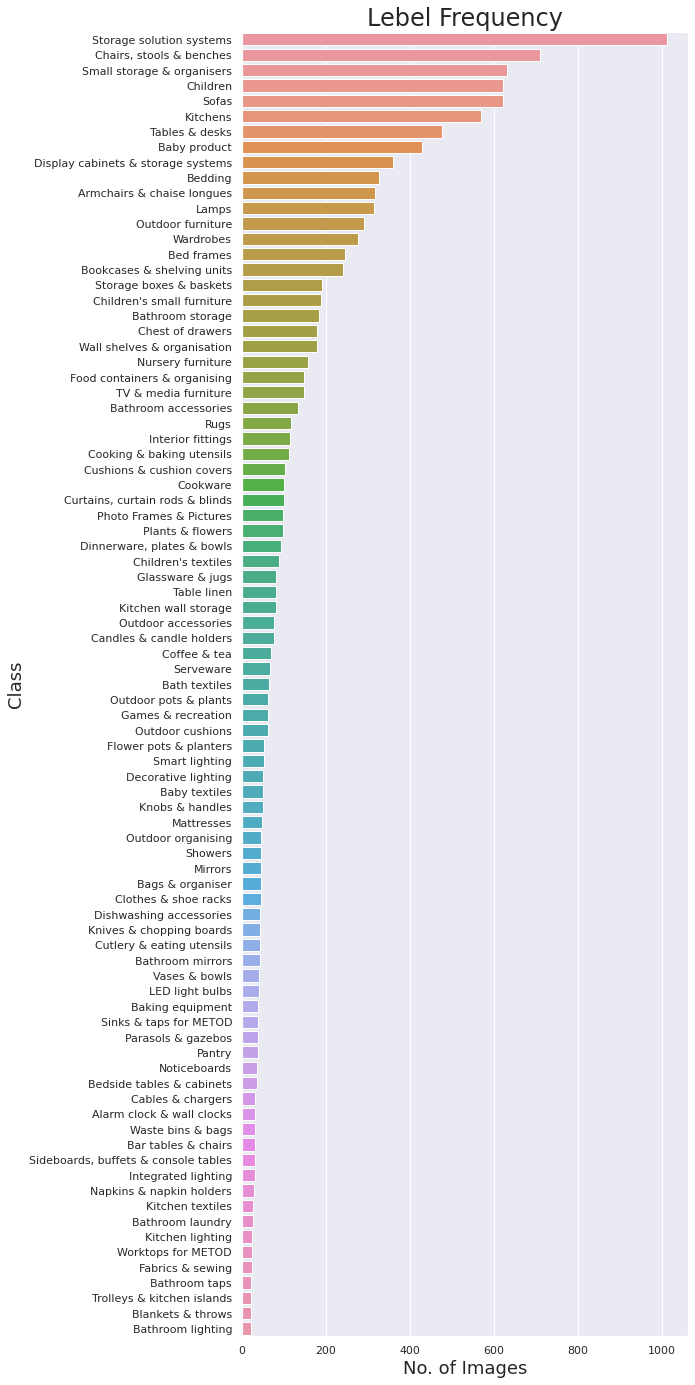

In [ ]:
#Visualization of the distribution of images by class

categories = image_file_path_df.label.value_counts().index.tolist()
sns.set(font_scale = 1)
plt.figure(figsize=(8,24))
ax= sns.barplot(image_file_path_df.label.value_counts(),categories)

plt.title("Lebel Frequency", fontsize=24)
plt.ylabel('Class', fontsize=18)
plt.xlabel('No. of Images', fontsize=18)

plt.show()


In [ ]:
#Hard to fit so many classes into sns barplot

image_file_path_df.label.value_counts()

Storage solution systems      1011
Chairs, stools & benches       709
Small storage & organisers     630
Children                       622
Sofas                          622
                              ... 
Fabrics & sewing                24
Bathroom taps                   23
Trolleys & kitchen islands      23
Blankets & throws               22
Bathroom lighting               22
Name: label, Length: 85, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


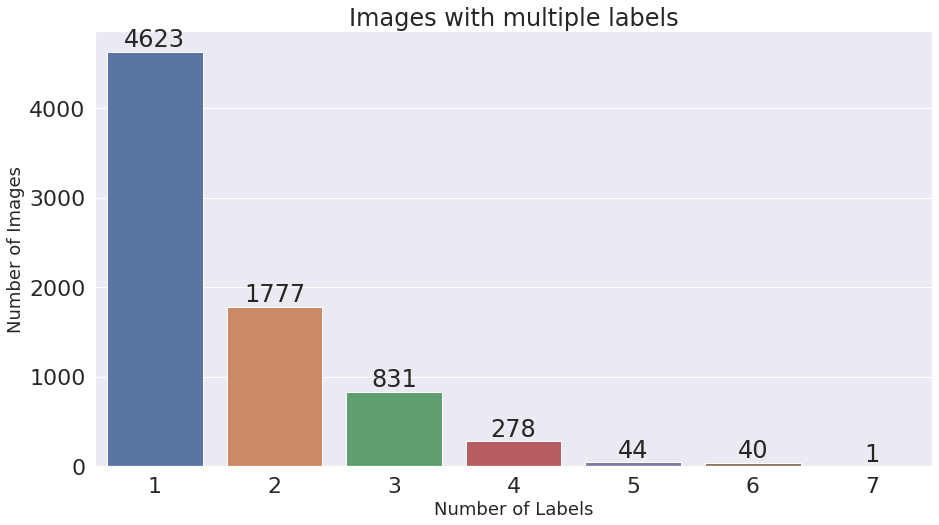

In [ ]:
#create a copy of the data_set to calculate how many multiple labels
data_set = image_file_path_df.copy()
data_set['image'] = image_file_path_df.image_file_path.str.split(pat = '/').str[2]
data_set = pd.melt(data_set,id_vars=['image'],value_vars=['label'])
data_set.image.value_counts().value_counts().tolist

cat_multi_labels = data_set.image.value_counts().value_counts().index.tolist()
mutilabel_counts = data_set.image.value_counts().value_counts()
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(cat_multi_labels,mutilabel_counts)

plt.title("Images with multiple labels", fontsize=24)
plt.ylabel('Number of Images', fontsize=18)
plt.xlabel('Number of Labels', fontsize=18)

rects = ax.patches
labels = mutilabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
from sklearn.utils import class_weight

#class_weights = dict(zip(np.unique(y_train_ori), class_weight.compute_class_weight('balanced', np.unique(y_train_ori), 
#                 y_train_ori))) 

# Fit data to model
# history = cnn_model.fit(X_train, y_train,
#           batch_size = batch_size,
#           epochs = no_epochs,
#           verbose = verbosity,
#           validation_data = (X_test, y_test),
#           shuffle = False,
#           class_weight = class_weights,
#           callbacks=[es, mc])


In [ ]:
cv2.imread(data_set_df['image'][1]).shape

NameError: ignored

In [ ]:
data_set_df['image']

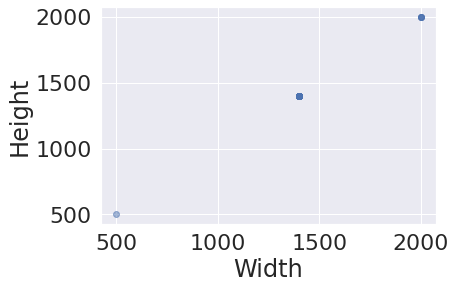

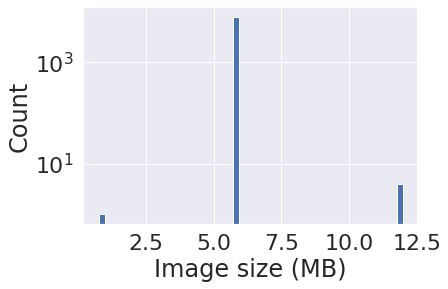

In [ ]:
height, width, size = np.empty(len(data_set_df)), np.empty(len(data_set_df)), np.empty(len(data_set_df)) 
for i, img_filepath in data_set_df['image'].iteritems():
    w, h, _ = cv2.imread(img_filepath).shape
    width[i], height[i], size[i] = w, h, w * h * 3 * 1E-6
plt.scatter(width, height, alpha=0.5)
plt.xlabel('Width'); plt.ylabel('Height'); plt.show()
plt.hist(size, bins=50, log=True)
plt.xlabel('Image size (MB)');
plt.ylabel('Count');


In [ ]:
img_list = data_set.image.unique().tolist()
labels = []
for id in img_list:
  labels.append(data_set[data_set.image == id].value.to_list())

In [ ]:
data_set_df = pd.DataFrame()
data_set_df['image']=img_list
data_set_df['labels']=labels

In [ ]:
# Prepare the training folder and image file list
image_folder_name = 'ikea_image'
image_file_link = []
for image in img_list:
  subfolder=data_set_df[data_set_df['image']==image]['labels'].tolist()[0][0]
  image_file_link.append(image_folder_name + '/' + subfolder + '/' + image)

data_set_df['image'] = image_file_link

In [ ]:
data_set_df.head()

,image,labels
0,ikea_image/Alarm clock & wall clocks/TROMMA_Wa...,[Alarm clock & wall clocks]
1,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,[Alarm clock & wall clocks]
2,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,[Alarm clock & wall clocks]
3,ikea_image/Alarm clock & wall clocks/KLOCKIS_C...,[Alarm clock & wall clocks]
4,ikea_image/Alarm clock & wall clocks/TJALLA_Wa...,[Alarm clock & wall clocks]


In [ ]:
#split data set into train and testing
X_train, X_val, y_train, y_val = train_test_split(data_set_df['image'], data_set_df['labels'], test_size=0.2, random_state=42)
print("Number of images for training: ", len(X_train))
print("Number of images for validation: ", len(X_val))

Number of images for training:  6075
Number of images for validation:  1519


In [ ]:
##Splitting data set in test and training set
#train_image_file_list, test_image_file_list, train_label, test_label = train_test_split(image_file_path_df.image_file_path, image_file_path_df.label, 
#                                                                                        test_size=0.2, random_state=42, stratify = image_file_path_df.label,
#                                                                                        shuffle=True)

##converting it into list
#train_image_file_list = train_image_file_list.to_list()
#test_image_file_list = test_image_file_list.to_list()

If you are familiar with keras.preprocessing you may know the image data iterators (E.g., ImageDataGenerator, DirectoryIterator). These iterators are convenient for multi-class classfication where the image directory contains one subdirectory for each class. But, in the case of multi-label classification, having an image directory that respects this structure is not possible because one observation can belong to multiple classes at the same time.



In [ ]:
X_train = list(X_train)
X_val = list(X_val)

In [ ]:
X_train[1]

'ikea_image/Storage solution systems/PAX_Wardrobe frame_50355121.jpg'

In [ ]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['Kitchens'], ['Storage solution systems'], ['Dinnerware, plates & bowls']]

Inspecting the file paths and image examples

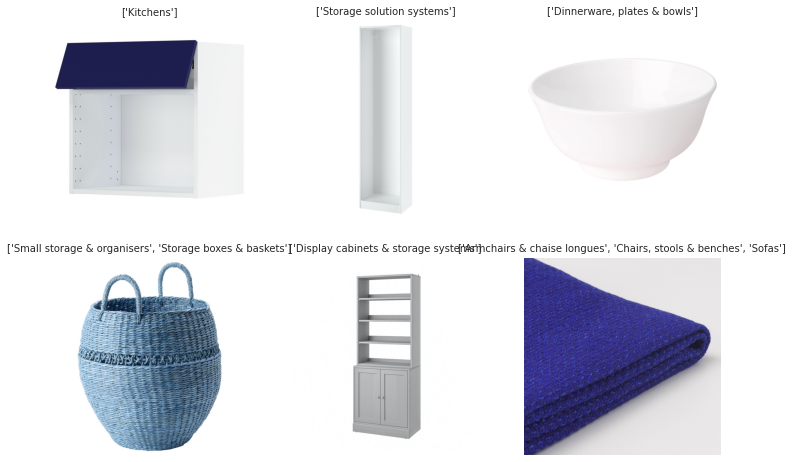

In [ ]:
nobs = 6 # Maximum number of images to display
ncols = 3 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

plt.figure(figsize=(12,4*nrows))
for ind in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, ind+1)
    plt.imshow(cv2.imread(X_train[ind]))
    plt.title(y_train[ind], size=10)
    plt.axis('off')

Label encoding by converting list of strings to binary labels also known as multi-hot encoding

In [ ]:
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))


Labels:
0. Alarm clock & wall clocks
1. Armchairs & chaise longues
2. Baby product
3. Baby textiles
4. Bags & organiser
5. Baking equipment
6. Bar tables & chairs
7. Bath textiles
8. Bathroom accessories
9. Bathroom laundry
10. Bathroom lighting
11. Bathroom mirrors
12. Bathroom storage
13. Bathroom taps
14. Bed frames
15. Bedding
16. Bedside tables & cabinets
17. Blankets & throws
18. Bookcases & shelving units
19. Cables & chargers
20. Candles & candle holders
21. Chairs, stools & benches
22. Chest of drawers
23. Children
24. Children's small furniture
25. Children's textiles
26. Clothes & shoe racks
27. Coffee & tea
28. Cooking & baking utensils
29. Cookware
30. Curtains, curtain rods & blinds
31. Cushions & cushion covers
32. Cutlery & eating utensils
33. Decorative lighting
34. Dinnerware, plates & bowls
35. Dishwashing accessories
36. Display cabinets & storage systems
37. Fabrics & sewing
38. Flower pots & planters
39. Food containers & organising
40. Games & recreation
41. Glas

Binarize the train and validation set

In [ ]:
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

Check whether binary targets instead of list of string

In [ ]:
for i in range(3):
    print(X_train[i], y_train_bin[i])

ikea_image/Kitchens/METOD_Wall cab for microwave ov w push-op_s29394365.jpg [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
ikea_image/Storage solution systems/PAX_Wardrobe frame_50355121.jpg [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0]
ikea_image/Dinnerware, plates & bowls/OFTAST_Rice bowl_70429946.jpg [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
data_set_df.head()


,image,labels
0,ikea_image/Alarm clock & wall clocks/TROMMA_Wa...,[Alarm clock & wall clocks]
1,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,[Alarm clock & wall clocks]
2,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,[Alarm clock & wall clocks]
3,ikea_image/Alarm clock & wall clocks/KLOCKIS_C...,[Alarm clock & wall clocks]
4,ikea_image/Alarm clock & wall clocks/TJALLA_Wa...,[Alarm clock & wall clocks]


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[2]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-041aa41111ff>", line 6, in <module>
    for image, _ in train_ds.take(1):
NameError: name 'train_ds' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/cor

NameError: ignored

In [ ]:
import tensorflow as tf

from tf.image.application.augmentation_config import (
    AugmentationConfig,
    AspectRatioAugmentation,
    ColorAugmentation,
)
from tf.image.application.tools import random_augmentations

image = tf.io.read_file("path/to/an/image.jpg")
image = tf.image.decode_jpeg(image)
bounding_boxes = tf.constant([[0.1, 0.2, 0.5, 0.3], [0.5, 0.3, 0.9, 0.1]])

config = AugmentationConfig()
config.color = ColorAugmentation.MILD
config.crop = True
config.distort_aspect_ratio = AspectRatioAugmentation.NONE
config.quality = True
config.erasing = True
config.rotate90 = False
config.rotate_max = 0
config.flip_vertical = True
config.flip_horizontal = False
config.padding_square = False

image, bounding_boxes = random_augmentations(image, config, bboxes=bounding_boxes)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-36e0ecba00fd>", line 3, in <module>
    from tf.image.application.augmentation_config import (
ModuleNotFoundError: No module named 'tf'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python3.7/inspect.py", line 1502,

ModuleNotFoundError: ignored

In [ ]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

def create_dataset(filenames, labels, augment=False, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    # if augment:
    #     dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), 
    #             num_parallel_calls=AUTOTUNE)
              
    
    return dataset


In [ ]:
IMG_SIZE = 224

train_ds = create_dataset(X_train, y_train_bin, augment=False)
val_ds = create_dataset(X_val, y_val_bin)

Each batch will be a pair of arrays (one that holds the features and another one that holds the labels).
The features array will be of shape (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS).
The labels array will be of shape (BATCH_SIZE, N_LABELS) where N_LABELS is the maximum number of labels.
Let's verify the shapes of these arrays by analyzing the first batch:



In [ ]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)


Shape of features array: (32, 224, 224, 3)
Shape of labels array: (32, 85)


In [ ]:
label_to_class = {v: k for k, v in img_iter.class_indices.items()}
def array_to_labels(onehot_array, label_to_class):
    labels = []
    idx = np.where(onehot_array == 1)[0]
    return [label_to_class[i] for i in idx]


NameError: ignored

In [ ]:
y_train[0]

['Kitchens']

In [ ]:
# from collections import Counter
# all_labels = [label for lbs in y_train for label in lbs]
# labels_count = Counter(all_labels)
# total_counts = sum(labels_count.values())
# class_weights = {img_iter.class_indices[cls]: total_counts / count for cls, count in labels_count.items()}
# class_weights


Download headless model

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))


In [ ]:
feature_extractor_layer.trainable = False


Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [ ]:
data_set_df


,image,labels
0,ikea_image/Alarm clock & wall clocks/TROMMA_Wa...,[Alarm clock & wall clocks]
1,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,[Alarm clock & wall clocks]
2,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,[Alarm clock & wall clocks]
3,ikea_image/Alarm clock & wall clocks/KLOCKIS_C...,[Alarm clock & wall clocks]
4,ikea_image/Alarm clock & wall clocks/TJALLA_Wa...,[Alarm clock & wall clocks]
...,...,...
7589,ikea_image/Wardrobes/PAX | HOKKSUND_Wardrobe c...,[Wardrobes]
7590,ikea_image/Wardrobes/PAX | TYSSEDAL_Wardrobe c...,[Wardrobes]
7591,ikea_image/Wardrobes/PAX | HOKKSUND_Wardrobe c...,[Wardrobes]
7592,ikea_image/Wardrobes/PAX | REPVÅG|VIKEDAL_War...,[Wardrobes]


In [ ]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

# x = cv2.imread(X_train[0])  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(x, batch_size=1,
#                           save_to_dir='temp', save_prefix='ikea', save_format='jpeg'):
#     i += 1
#     if i > 20:
#         break  # otherwise the generator would loop indefinitely


# from keras.preprocessing.image import ImageDataGenerator

# img_iter = ImageDataGenerator().flow_from_dataframe(
#     data_set_df,
#     x_col='image',
#     y_col='labels',
#     class_mode='categorical'
# )

# model.fit_generator(img_iter)


In [ ]:


model = tf.keras.Sequential([
    # data_augmentation,
    # layers.Conv2D(16, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 85)                87125     
Total params: 3,656,853
Trainable params: 1,398,869
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

[[0.3791022  0.43779796 0.19160481 0.6830227  0.61686164 0.7887576
  0.1386444  0.62841666 0.48588917 0.52372515 0.5306585  0.65596074
  0.49312294 0.5119942  0.65983814 0.4271465  0.36767486 0.65788966
  0.30178428 0.22747554 0.27661192 0.4686337  0.500446   0.5279853
  0.41222495 0.59010494 0.4815588  0.32510772 0.32111037 0.47913143
  0.49919403 0.45157212 0.6429201  0.57671595 0.2903415  0.2953601
  0.5302779  0.3807875  0.7246637  0.4057631  0.15119384 0.77441597
  0.6229892  0.66388464 0.7290614  0.6980326  0.5175318  0.28053856
  0.5598844  0.4858542  0.5087782  0.47728497 0.34994784 0.8002982
  0.74554735 0.67680705 0.5426185  0.3028275  0.4224207  0.5010964
  0.57314533 0.4327919  0.5794482  0.5268356  0.71747595 0.6435137
  0.5055963  0.73554    0.6397087  0.4154541  0.46496198 0.4106263
  0.4621237  0.3452217  0.6182709  0.5996878  0.36711493 0.47040895
  0.6247898  0.58287156 0.6617469  0.37766618 0.5426216  0.66885895
  0.44463155]]


In [ ]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [ ]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
def cal_precision(input_file_name, result_file_name_list):
    num = 0
    id = re.search(r'.*_(\d*)', input_file_name.split("/")[2]).group(1)
    input_class = all_data[all_data.id == id].category_name.to_list()
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[1]
        if result_class in input_class:
            num = num+1
    return (num/len(result_file_name_list))

def cal_accuracy(input_file_name, result_file_name_list):
    result = 0
    id = re.search(r'.*_(\d*)', input_file_name.split("/")[2]).group(1)
    input_class = all_data[all_data.id == id].category_name.to_list()
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[1]
        if result_class in input_class:
            result = 1
            break
    return (result)

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)

Train the model using the macro soft-F1 loss.
Specify the learning rate and the number of training epochs (number of loops over the whole dataset).

In [ ]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30


In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score)
from itertools import tee  # finally! I found something useful for it
from sklearn import metrics


class Metrics(Callback):
    def __init__(self, validation_generator, validation_steps=None, threshold=0.5):
        self.validation_generator = validation_generator
        self.validation_steps = validation_steps or len(validation_generator)
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.val_f1_scores = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        gen_1, gen_2 = itertools.tee(self.validation_generator)
        y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
        y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')
        _val_f1 = f1_score(y_true, y_pred, average='weighted')
        _val_recall = recall_score(y_true, y_pred, average='weighted')
        _val_precision = precision_score(y_true, y_pred, average='weighted')
        self.val_f1_scores.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" - val_f1_score: {_val_f1:.5f} - val_precision: {_val_precision:.5f} - val_recall: {_val_recall:.5f}")
        return


Compile the model to configure the training process.



In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1#,cal_precision, cal_accuracy,cal_vec_dist
           #,
           #Metrics(img_iter_val, validation_steps=10)
           ])




Now, we pass the training dataset of (features, labels) to fit the model and indicate a seperate dataset for validation.
The performance on the validation dataset will be measured after each epoch.



In [ ]:
#start
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    #class_weight=class_weights,
                    validation_data=create_dataset(X_val, y_val_bin))

# end time
end = time()

# total time taken

seconds = (end - start)

def sec_to_hours(seconds):
    a=str(seconds//3600)
    b=str((seconds%3600)//60)
    c=str(round((seconds%3600)%60,2))
    d=["{} hours {} mins {:} seconds".format(a, b, c)]
    return d

print(f"Runtime of the program is {sec_to_hours(seconds)}")

Epoch 1/30
190/190 [==============================] - 678s 4s/step - loss: 0.9649 - macro_f1: 0.0401 - val_loss: 0.9574 - val_macro_f1: 0.0666
Epoch 2/30
190/190 [==============================] - 6s 32ms/step - loss: 0.9547 - macro_f1: 0.0744 - val_loss: 0.9451 - val_macro_f1: 0.0930
Epoch 3/30
190/190 [==============================] - 6s 32ms/step - loss: 0.9406 - macro_f1: 0.1009 - val_loss: 0.9293 - val_macro_f1: 0.1144
Epoch 4/30
190/190 [==============================] - 6s 32ms/step - loss: 0.9251 - macro_f1: 0.1197 - val_loss: 0.9161 - val_macro_f1: 0.1242
Epoch 5/30
190/190 [==============================] - 6s 32ms/step - loss: 0.9087 - macro_f1: 0.1375 - val_loss: 0.9024 - val_macro_f1: 0.1359
Epoch 6/30
190/190 [==============================] - 6s 32ms/step - loss: 0.8958 - macro_f1: 0.1482 - val_loss: 0.8953 - val_macro_f1: 0.1404
Epoch 7/30
190/190 [==============================] - 6s 32ms/step - loss: 0.8855 - macro_f1: 0.1556 - val_loss: 0.8842 - val_macro_f1: 0.1477

In [ ]:
# import itertools

# nr_batches = 10
# threshold = 0.5
# img_iter_val_0, img_iter_val_1 = itertools.tee(img_iter_val, 2)
# y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(nr_batches)).astype('int')
# y_pred = (model.predict_generator(img_iter_val_1, steps=nr_batches) > threshold).astype('int')
# plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False)


In [ ]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    plt.figure(figsize=(12, 12))
    plt.rcParams.update({'font.size':1})

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')


    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1


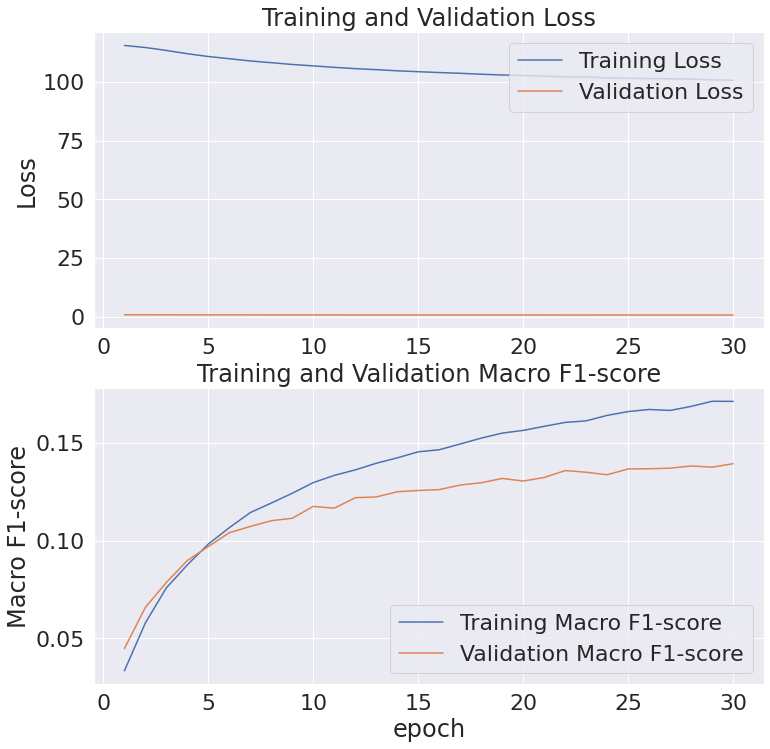

In [ ]:

losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)


In [ ]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])


Macro soft-F1 loss: 0.87
Macro F1-score: 0.14


Train the model using the binary cross-entropy loss
We will train a similar model but this time, instead of using the macro soft-F1 loss, we will be using the binary cross-entropy loss.



In [ ]:
model_bce = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))

# end time
end = time()

# total time taken

seconds = (end - start)

def sec_to_hours(seconds):
    a=str(seconds//3600)
    b=str((seconds%3600)//60)
    c=str(round((seconds%3600)%60,2))
    d=["{} hours {} mins {:} seconds".format(a, b, c)]
    return d

print(f"Runtime of the program is {sec_to_hours(seconds)}")

Epoch 1/30
193/193 [==============================] - 17s 84ms/step - loss: 0.1611 - macro_f1: 0.0071 - val_loss: 0.0516 - val_macro_f1: 0.0245
Epoch 2/30
193/193 [==============================] - 6s 33ms/step - loss: 0.0474 - macro_f1: 0.0321 - val_loss: 0.0435 - val_macro_f1: 0.0501
Epoch 3/30
193/193 [==============================] - 6s 32ms/step - loss: 0.0394 - macro_f1: 0.0592 - val_loss: 0.0394 - val_macro_f1: 0.0641
Epoch 4/30
193/193 [==============================] - 6s 33ms/step - loss: 0.0349 - macro_f1: 0.0792 - val_loss: 0.0370 - val_macro_f1: 0.0778
Epoch 5/30
193/193 [==============================] - 6s 32ms/step - loss: 0.0315 - macro_f1: 0.0950 - val_loss: 0.0354 - val_macro_f1: 0.0888
Epoch 6/30
193/193 [==============================] - 6s 32ms/step - loss: 0.0290 - macro_f1: 0.1040 - val_loss: 0.0342 - val_macro_f1: 0.0940
Epoch 7/30
193/193 [==============================] - 6s 33ms/step - loss: 0.0269 - macro_f1: 0.1124 - val_loss: 0.0332 - val_macro_f1: 0.100

Visualize the learning curves on the training and validation datasets when using the binary cross entropy loss.
The function that plots learning curves was implemented in module utils.

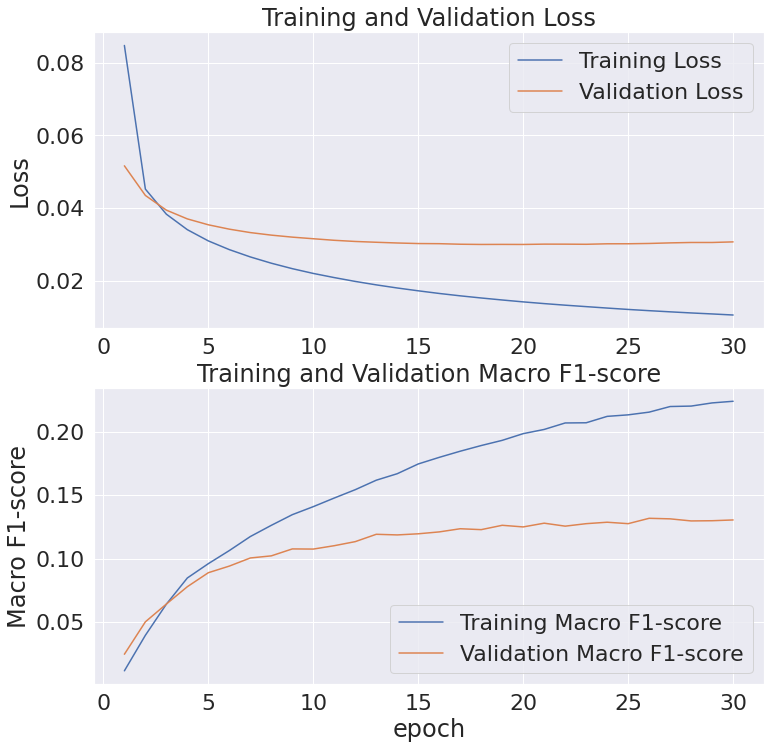

In [ ]:
model_bce_losses, model_bce_val_losses, model_bce_macro_f1s, model_bce_val_macro_f1s = learning_curves(history_bce)


Indicate the performance measured on the validation set

In [ ]:

print("Macro soft-F1 loss: %.2f" %model_bce_val_losses[-1])
print("Macro F1-score: %.2f" %model_bce_val_macro_f1s[-1])

Macro soft-F1 loss: 0.03
Macro F1-score: 0.13


Decision Threshold

There is a function named perf_grid in the utils module that helps create the performance grid.
In the performance grid, thresholds increment from 0 to 1 by a step of 0.01 for each label.
For each threshold and for each label, we compute different measures (tp, fn, fp, precision, recall, f1-score).



In [ ]:
def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid

In [ ]:
# Get all label names
label_names = mlb.classes_
# Performance table with the first model (macro soft-f1 loss)
grid = perf_grid(val_ds, y_val_bin, label_names, model)
# Performance table with the second model (binary cross-entropy loss)
grid_bce = perf_grid(val_ds, y_val_bin, label_names, model_bce)

In [ ]:
grid_bce.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,Alarm clock & wall clocks,0.0,0.00,7,0,1537,0.004534,1.0,0.009026
1,0,Alarm clock & wall clocks,0.0,0.01,0,7,8,0.000000,0.0,0.000000
2,0,Alarm clock & wall clocks,0.0,0.02,0,7,7,0.000000,0.0,0.000000
3,0,Alarm clock & wall clocks,0.0,0.03,0,7,7,0.000000,0.0,0.000000
4,0,Alarm clock & wall clocks,0.0,0.04,0,7,7,0.000000,0.0,0.000000


In [ ]:
# Get the maximum F1-score for each label when using the second model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,102,Storage solution systems,0.120000,0.218119
1,28,"Chairs, stools & benches",0.100000,0.180318
2,99,Sofas,0.090000,0.169532
3,31,Children,0.080000,0.162465
4,4,Baby textiles,0.010000,0.153846
5,96,Small storage & organisers,0.080000,0.152005
6,105,Tables & desks,0.070000,0.127350
7,63,Kitchens,0.070000,0.123937
8,3,Baby product,0.060000,0.110818
9,46,Dishwashing accessories,0.010000,0.100000


In [ ]:
print("Correlation between label frequency and optimal F1 with bce: %.2f" %max_perf['freq'].corr(max_perf['f1max_bce']))


Correlation between label frequency and optimal F1 with bce: 0.89


In [ ]:
top5 = max_perf.head(5)['id']


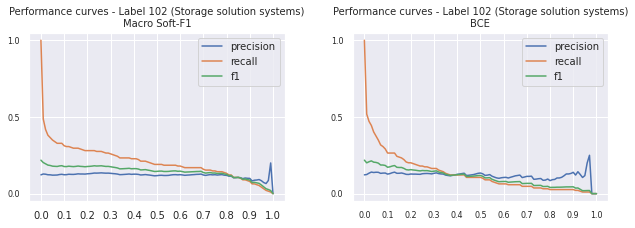

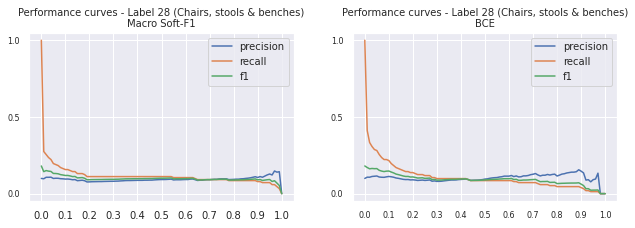

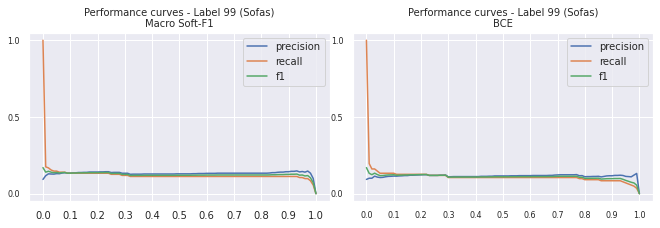

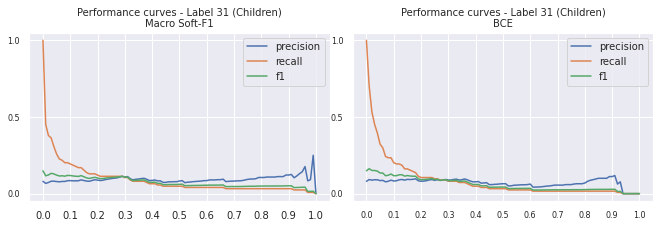

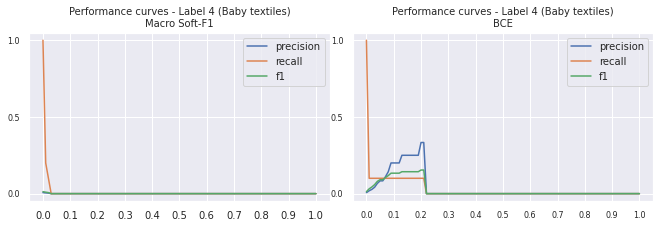

In [ ]:

for l in top5:
    
    label_grid = grid.loc[grid['id']==l, ['precision','recall','f1']]
    label_grid = label_grid.reset_index().drop('index', axis=1)
    
    label_grid_bce = grid_bce.loc[grid_bce['id']==l, ['precision','recall','f1']]
    label_grid_bce = label_grid_bce.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,3))

    plt.rc('legend',fontsize=10)

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    label_grid.plot(ax=ax)
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    label_grid_bce.plot(ax=ax)
    
    plt.tight_layout()
    plt.show()


When training the model using the macro soft-F1 loss, we get an F1-score that is almost independent of the threshold. We don't have this effect when using the binary cross-entropy loss. It is actually an interesting effect because it offers the possibility to fix the threshold at 0.5 for all labels and still get a performance close to the one we would obtain by searching for an optimal threshold when using the BCE loss. When it comes to building production ML systems, this is a very nice feature. Updating the thresholds and making sure they remain optimal on new coming data is a lot of effort. Using the macro soft-F1 loss can help solve that problem, but actually where does that behaviour come from?



In [ ]:
# Predict on the validation set with both models
y_hat_val = model.predict(val_ds)
y_hat_val_bce = model_bce.predict(val_ds)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


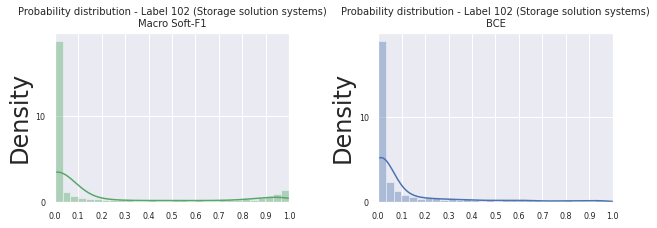

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


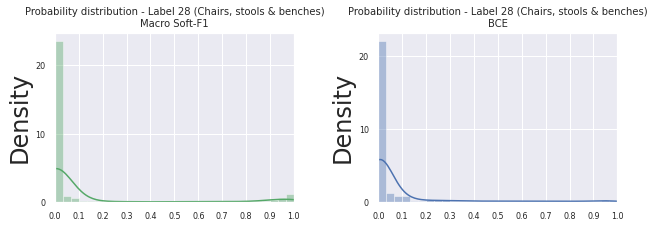

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


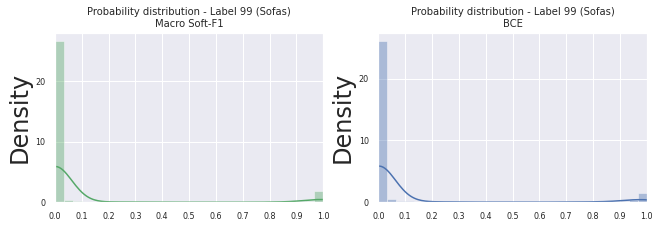

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


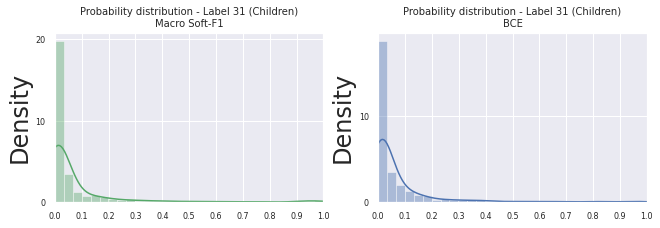

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


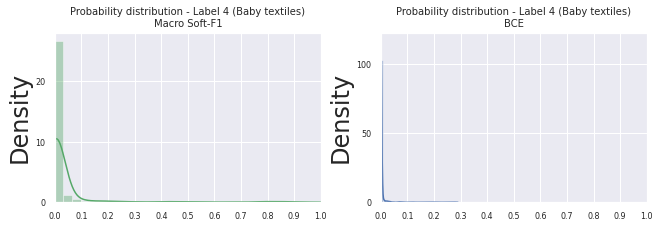

In [ ]:

for l in top5:
        
    plt.figure(figsize=(9,3))
    
    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val[:,l], bins=30, kde=True, color="g")
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val_bce[:,l], bins=30, kde=True, color="b")
    
    plt.tight_layout()
    plt.show()


When training using the binary cross-entropy loss, the probability distribution of the output has some gaussian properties (notice the bell shape of the blue histograms). Actually, this optimization learns from the original distribution of the data. We can see that for label 'Drama' which coveres 50% of the dataset, the probability distribution is centred at 0.5. By the way, the classifier that was built for 'Drama' appears to be very weak as both classes do not appear to be separated in probability values. We can also notice that the less frequent a label is, the more shifted to the left the distribution will be. For example, probability scores appear to be very low for 'Crime' and this label coveres only 14% of the dataset. The model learns from this rarity to predict lower probability values. On the other hand, when using the macro soft-F1 loss, we are creating a system that does not reflect the same magnitude of conditional probability values. Instead, it learns to be less hesitating and generates predictions that are either very close to 1 or very close to 0. We have less probability values in the middle range. So, the performance does not change too much when varying the threshold in that range.


Optimizing with the macro soft-F1 loss could replace some exhaustive techniques like:

Searching for the optimal decision threshold that maximizes performance on a validation set
Calibrating probability values by oversampling a minority class or undersampling a majority class before training (very complex in case of multi-label classification)


In [ ]:
data_set_df.head()

,image,labels
0,ikea_image/Alarm clock & wall clocks/TROMMA_Wa...,[Alarm clock & wall clocks]
1,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,[Alarm clock & wall clocks]
2,ikea_image/Alarm clock & wall clocks/FILMIS_Cl...,[Alarm clock & wall clocks]
3,ikea_image/Alarm clock & wall clocks/KLOCKIS_C...,[Alarm clock & wall clocks]
4,ikea_image/Alarm clock & wall clocks/TJALLA_Wa...,[Alarm clock & wall clocks]


In [ ]:
data_set_df[data_set_df['image'].str.contains("clock")][:1].iloc[0,0]

'ikea_image/Alarm clock & wall clocks/TROMMA_Wall clock_60454291.jpg'

In [ ]:
def show_prediction(item, df, model):
    
    # Get testing only one image 
    temp_df = df[df['image'].str.contains(item)][:1]
    img_path = temp_df.iloc[0,0]
    labels = temp_df.iloc[0,1]

    # Read and prepare image
    img_string = tf.io.read_file(img_path)
    img_decoded = tf.image.decode_jpeg(img_string, channels=CHANNELS)
    img_resized = tf.image.resize(img_decoded, [IMG_SIZE, IMG_SIZE])
    img = img_resized/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.6).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    plt.figure(figsize=(8,4))
    plt.imshow(cv2.imread(img_path))
    plt.axis('off')
    plt.grid(b=None)

    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(item, labels, list(prediction)), fontsize=9)
    plt.show()


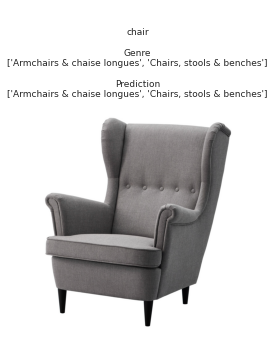

In [ ]:
show_prediction('chair', data_set_df, model)


In [ ]:
#img_path ='data/bartleysofa.jpg'

# Read and prepare image
img_string = tf.io.read_file(img_path)
img_decoded = tf.image.decode_jpeg(img_string, channels=CHANNELS)
img_resized = tf.image.resize(img_decoded, [IMG_SIZE, IMG_SIZE])
img = img_resized/255
img = np.expand_dims(img, axis=0)

# Generate prediction
prediction = (model.predict(img) > 0.5).astype('int')
prediction = pd.Series(prediction[0])
prediction.index = mlb.classes_
prediction = prediction[prediction==1].index.values

# Dispaly image with prediction
plt.figure(figsize=(8,4))
plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.grid(b=None)

plt.title('\n\n{}\n\nPrediction\n{}\n'.format(img_path, list(prediction)), fontsize=9)
plt.show()

NameError: ignored

In [ ]:
nobs = 6 # Maximum number of images to display
ncols = 3 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

plt.figure(figsize=(12,4*nrows))
for ind in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, ind+1)
    plt.imshow(cv2.imread(X_train[ind]))
    plt.title(y_train[ind], size=10)
    plt.axis('off')

NameError: ignored

In [ ]:
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
model.save(export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

export_path_bce = "./models/bce_{}".format(t)
model_bce.save(export_path_bce)
print("Model with bce was exported in this path: '{}'".format(export_path_bce))

We can later reload a tf.keras model by specifying the path to the export directory containing the .pb file

In [ ]:
model = tf.keras.models.load_model('models/soft-f1_20210508_220232', compile=False,custom_objects={"F1Score": tfa.metrics.F1Score})

NameError: ignored

In [ ]:
IMG_SIZE = 299

train_ds = create_dataset(X_train, y_train_bin, augment=False)
val_ds = create_dataset(X_val, y_val_bin)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)


Shape of features array: (32, 299, 299, 3)
Shape of labels array: (32, 117)


In [ ]:
model_inceptionv3 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", output_shape=[2048],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(N_LABELS, activation='sigmoid')
])
model_inceptionv3.build([None, 299, 299, 3])  # Batch input shape.

model_inceptionv3.summary()

model_inceptionv3.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_model_inceptionv3 = model_inceptionv3.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))

# end time
end = time()

# total time taken

seconds = (end - start)
print(f"Runtime of the program is {sec_to_hours(seconds)}")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 85)                174165    
Total params: 21,976,949
Trainable params: 174,165
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/30
190/190 [==============================] - 73s 344ms/step - loss: 0.1499 - macro_f1: 0.0090 - val_loss: 0.0676 - val_macro_f1: 0.0299
Epoch 2/30
190/190 [==============================] - 17s 91ms/step - loss: 0.0625 - macro_f1: 0.0407 - val_loss: 0.0577 - val_macro_f1: 0.0607
Epoch 3/30
190/190 [==============================] - 17s 91ms/step - loss: 0.0526 - macro_f1: 0.0712 - val_loss: 0.0521 - val_macro_f1: 0.0860
Epoch 4/30
190/190 [==============================] - 17s 91ms/st

In [ ]:
model_inceptionv3 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", output_shape=[2048],
                   trainable=False),  # Can be True, see below.
                   layers.Dense(1024, activation='relu', name='hidden_layer'),
                   tf.keras.layers.Dense(N_LABELS, activation='sigmoid')
                   ])

model_inceptionv3.build([None, 299, 299, 3])  # Batch input shape.

model_inceptionv3.summary()

model_inceptionv3.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_model_inceptionv3 = model_inceptionv3.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))

# end time
end = time()

# total time taken

seconds = (end - start)
print(f"Runtime of the program is {sec_to_hours(seconds)}")

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_19 (KerasLayer)  (None, 2048)              21802784  
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              2098176   
_________________________________________________________________
dense_12 (Dense)             (None, 117)               119925    
Total params: 24,020,885
Trainable params: 2,218,101
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/30
193/193 [==============================] - 34s 149ms/step - loss: 0.1050 - macro_f1: 0.0192 - val_loss: 0.0396 - val_macro_f1: 0.0608
Epoch 2/30
193/193 [==============================] - 18s 94ms/step - loss: 0.0362 - macro_f1: 0.0765 - val_loss: 0.0348 - val_macro_f1: 0.0873
Epoch 3/30
193/193 [==============================] - 18s 94ms/step - loss

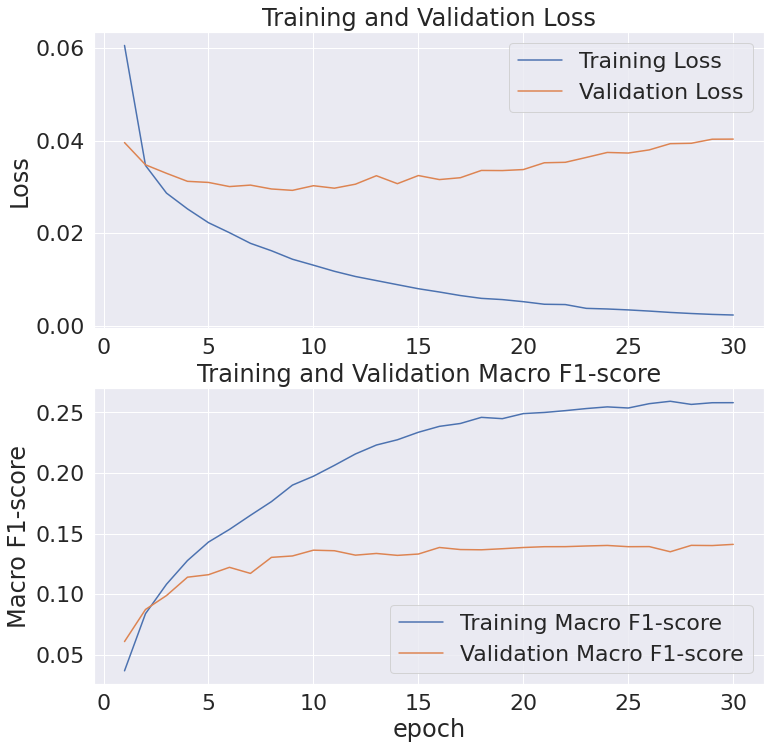

Macro soft-F1 loss: 0.04
Macro F1-score: 0.14


In [ ]:
model_inception_losses, model_inception_val_losses, model_inception_macro_f1s, model_inception_val_macro_f1s = learning_curves(history_model_inceptionv3
                                                                                                                               )
print("Macro soft-F1 loss: %.2f" %model_inception_val_losses[-1])
print("Macro F1-score: %.2f" %model_inception_val_macro_f1s[-1])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_inceptionv3 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", output_shape=[2048],
                   trainable=False),  # Can be True, see below.
                   layers.Dense(1024, activation='relu', name='hidden_layer'),
                   tf.keras.layers.Dense(N_LABELS, activation='sigmoid')
                   ])


model_inceptionv3.build([None, 299, 299, 3])  # Batch input shape.

model_inceptionv3.summary()

model_inceptionv3.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()

checkpoint_filepath = '/temp/checkpoint'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
mc = ModelCheckpoint('/temp/checkpoint/best_inception_model.h5', monitor='val_macro_f1', mode='max', verbose=1, save_best_only=True)

history_model_inceptionv3 = model_inceptionv3.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin),
                            callbacks=[es,mc])



# end time
end = time()

# total time taken

seconds = (end - start)
print(f"Runtime of the program is {sec_to_hours(seconds)}")

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_18 (KerasLayer)  (None, 2048)              21802784  
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              2098176   
_________________________________________________________________
dense_11 (Dense)             (None, 117)               119925    
Total params: 24,020,885
Trainable params: 2,218,101
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/30
193/193 [==============================] - 35s 150ms/step - loss: 0.1024 - macro_f1: 0.0199 - val_loss: 0.0404 - val_macro_f1: 0.0648

Epoch 00001: val_macro_f1 improved from -inf to 0.06479, saving model to /temp/checkpoint/best_inception_model.h5
Epoch 2/30
193/193 [==============================] - 18s 95ms/step - loss: 0.0355 - macro_f1: 0.0780 -

In [ ]:
new_model=tf.keras.models.load_model("./model.h5",custom_objects={'customLoss1':customLoss1,'customLoss2':customLoss2})



In [ ]:
IMG_SIZE = 244

train_ds = create_dataset(X_train, y_train_bin, augment=False)
val_ds = create_dataset(X_val, y_val_bin)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

model_resnet50 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5",
                   trainable=False),  # Can be True, see below.
                   layers.Dense(1024, activation='relu', name='hidden_layer'),
                   tf.keras.layers.Dense(N_LABELS, activation='sigmoid')
                   ])

model_resnet50.build([None, 244, 244, 3])  # Batch input shape.

model_resnet50.summary()

model_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_model_resnet50 = model_resnet50.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))

# end time
end = time()

# total time taken

seconds = (end - start)
print(f"Runtime of the program is {sec_to_hours(seconds)}")


Shape of features array: (32, 244, 244, 3)
Shape of labels array: (32, 117)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              25615849  
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1026048   
_________________________________________________________________
dense_2 (Dense)              (None, 117)               119925    
Total params: 26,761,822
Trainable params: 1,145,973
Non-trainable params: 25,615,849
_________________________________________________________________
Epoch 1/30
193/193 [==============================] - 310s 2s/step - loss: 0.1159 - macro_f1: 0.0427 - val_loss: 0.0366 - val_macro_f1: 0.0900
Epoch 2/30
193/193 [==============================] - 15s 79ms/step - loss: 0.0302 - macro_f1: 0.1064 - val_loss: 0.0327 - val_macro_f1: 0.1093
E

NameError: ignored

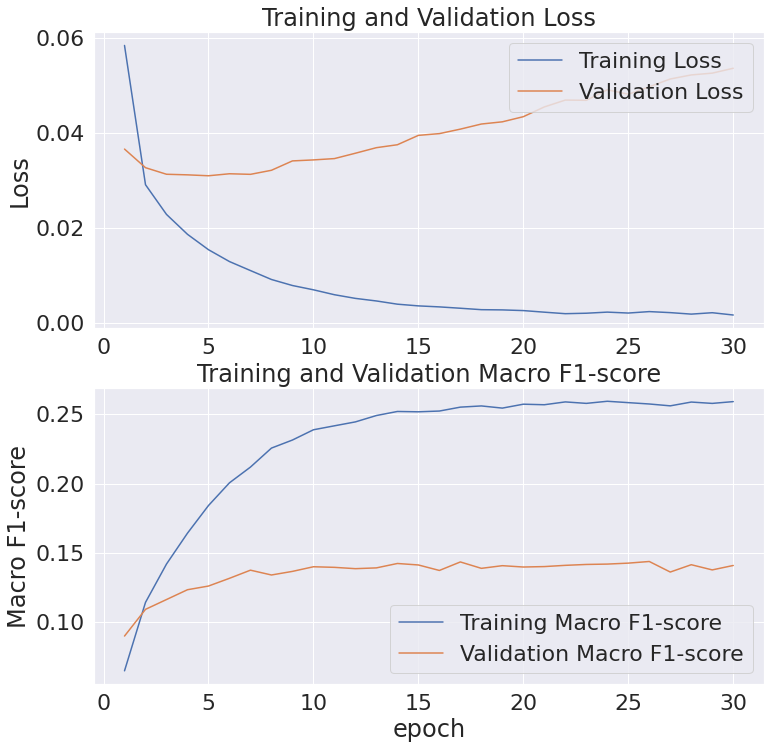

Macro soft-F1 loss: 0.05
Macro F1-score: 0.14


In [ ]:

losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history_model_resnet50)


print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])


In [ ]:
import re
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import random
import cv2
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

# Check GPU setup in Colab
import tensorflow as tf

# Silence the tensorflow warning message
tf.get_logger().setLevel('ERROR')

# Check GPU coinfiguration in Colab (T4 GPU)
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'